# 主題：新聞文本NLP處理與真假新聞分類
#### 第十三組 第三次讀書會專案
組員：
N124020001 林坤郁
N124020004 陳忠泰
N124020005 陳莘惠
N124020006 張祐倫
N124020012 郭展州
<br>
<h2>一、資料簡介與目標</h2> <h3>1.1 資料簡介</h3> 資料來源 Kaggle: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv
本專案使用的資料集為 Fake and Real News Dataset，由 Kaggle 提供，原始資料包含兩個檔案：

<ol> <li>Fake.csv：包含假新聞（Fake News），共 23,481 筆</li> <li>True.csv：包含真新聞（Real News），共 21,417 筆</li> </ol> 每筆資料具有以下欄位： <ol> <li>title：新聞標題</li> <li>text：新聞文字內容</li> <li>subject：主題類別，如政治、世界新聞等</li> <li>date：新聞發布時間</li> </ol>
在資料前處理階段，我們將兩份資料加上標籤（label），其中：
假新聞（Fake）標記為 0；真新聞（True）標記為 1，並合併成一份整合資料集，總計 44,898 筆資料。經過清理（移除空 tokens），最終保留 44,270 筆資料供後續分析與分類任務使用。

<h3>1.2 目標</h3> 本次專案主要任務為： <ol> <li>觀察資料特性與分佈，包含假/真新聞的主題與用詞差異</li> <li>利用新聞文本內容來辨識新聞真偽（即真假新聞分類任務）。這是一個典型的二元分類問題（Binary Classification），我們透過不同的文本表示方式（Text Embedding）與 BERT 技術，建立分類模型，判斷一篇新聞是「真」還是「假」。此外，分析假/真新聞的主題與特徵差異，挖掘其內容特性</li> </ol>

# **階段一：Text Embedding 分析** <br>
1.安裝必要套件。<br>
2.載入與前處理資料集（Fake.csv 和 True.csv）<br>
3.訓練 Word2Vec 模型並生成詞向量<br>
4.使用 Sentence Transformers 生成句子嵌入<br>
5.進行分類任務（Logistic Regression）<br>
6.視覺化分類結果與分析<br>
7.記錄分析洞察與限制<br>



**步驟 1：安裝必要套件**

In [1]:
# 清除舊套件以避免衝突
!pip uninstall -y numpy scipy gensim sentence-transformers transformers pandas scikit-learn matplotlib seaborn nltk spacy

# 安裝相容版本的套件
!pip install numpy>=1.26.4 gensim==4.3.2 scipy==1.10.1
!pip install transformers==4.44.2 sentence-transformers
!pip install pandas scikit-learn matplotlib seaborn nltk spacy
!python -m spacy download en_core_web_sm

# 匯入套件
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing

# 下載 NLTK 資源
nltk.download('punkt')
nltk.download('stopwords')

# 載入 spaCy 英文模型
nlp = spacy.load('en_core_web_sm')

# 設定停用詞
stop_words = set(stopwords.words('english'))

# 檢查關鍵套件版本
print("NumPy 版本:", np.__version__)
print("Transformers 版本:", __import__('transformers').__version__)
print("Gensim 版本:", __import__('gensim').__version__)
print("SciPy 版本:", __import__('scipy').__version__)

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.10.1
Uninstalling scipy-1.10.1:
  Successfully uninstalled scipy-1.10.1
Found existing installation: gensim 4.3.2
Uninstalling gensim-4.3.2:
  Successfully uninstalled gensim-4.3.2
Found existing installation: sentence-transformers 4.1.0
Uninstalling sentence-transformers-4.1.0:
  Successfully uninstalled sentence-transformers-4.1.0
Found existing installation: transformers 4.44.2
Uninstalling transformers-4.44.2:
  Successfully uninstalled transformers-4.44.2
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.17.6 requires matplotlib>=3.0.0, which is not installed.
datascience 0.17

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NumPy 版本: 1.26.4
Transformers 版本: 4.44.2
Gensim 版本: 4.3.2
SciPy 版本: 1.10.1


In [22]:
# 上傳 Kaggle API Token(kaggle.json) 到 Colab
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [14]:
# 下載 Kaggle 資料集
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset
!unzip fake-and-real-news-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
License(s): CC-BY-NC-SA-4.0
fake-and-real-news-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  fake-and-real-news-dataset.zip
replace Fake.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Fake.csv                
replace True.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: True.csv                


In [2]:
# 掛載 Google Drive 以儲存 Notebook：
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**步驟 2：載入與前處理資料集** <br>

1.載入 Fake.csv 和 True.csv，合併並標記類別（假新聞=0，真新聞=1）。<br>
2.使用 spaCy 進行斷詞，取代 nltk.word_tokenize，確保空 tokens 比例 < 5%<br>
nltk.word_tokenize 對長文本或非標準內容（如 HTML 殘留）易失敗，spaCy 更穩定。

In [3]:
# 載入資料
fake = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rowdata/Fake.csv')
true = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rowdata/True.csv')

# 標記類別
fake['label'] = 0  # 假新聞
true['label'] = 1  # 真新聞

# 合併資料
data = pd.concat([fake, true], ignore_index=True)

# 檢查資料
print("資料總筆數:", len(data))
print("類別分佈:\n", data['label'].value_counts())

# 前處理函式
def preprocess_text(text):
    if not isinstance(text, str):  # 處理非字符串
        return ""
    # 移除 HTML 標籤、特殊字符
    text = re.sub(r'<.*?>|[^a-zA-Z\s]', '', text)
    # 轉小寫
    text = text.lower()
    # 使用 spaCy 斷詞
    doc = nlp(text, disable=['parser', 'ner'])  # 禁用不必要功能以加速
    # 篩選詞彙：移除停用詞、標點，保留長度 > 1 的詞
    tokens = [token.text for token in doc if token.text not in stop_words and len(token.text) > 1 and not token.is_punct]
    return tokens if tokens else []

# 分批處理資料
batch_size = 5000
tokens_list = []

for i in range(0, len(data), batch_size):
    batch = data['text'][i:i+batch_size].apply(preprocess_text)
    tokens_list.extend(batch)
    print(f"已處理 {i+batch_size if i+batch_size < len(data) else len(data)} 筆資料")

# 將 tokens 加入資料框
data['tokens'] = tokens_list

# 檢查空 tokens
empty_tokens = data['tokens'].apply(len) == 0
empty_ratio = empty_tokens.mean()
print(f"空 tokens 比例: {empty_ratio:.2%}")

# 移除空 tokens 的資料
data_cleaned = data[~empty_tokens].reset_index(drop=True)
print(f"清理後資料筆數: {len(data_cleaned)}")

# 儲存清理後的資料
data_cleaned.to_csv('cleaned_news_data.csv', index=False)

資料總筆數: 44898
類別分佈:
 label
0    23481
1    21417
Name: count, dtype: int64
已處理 5000 筆資料
已處理 10000 筆資料
已處理 15000 筆資料
已處理 20000 筆資料
已處理 25000 筆資料
已處理 30000 筆資料
已處理 35000 筆資料
已處理 40000 筆資料
已處理 44898 筆資料
空 tokens 比例: 1.40%
清理後資料筆數: 44270


1.總筆數：44,898 筆（假新聞 23,481 筆，真新聞 21,417 筆）。<br>
2.空 tokens 比例：1.40%（遠低於 5%，表示 spaCy 斷詞有效）。<br>
3.清理後資料筆數：44,270 筆（僅移除 ~628 筆無效資料）。<br>

**步驟 3：訓練 Word2Vec 模型並生成詞向量** <br>
1.使用 gensim.Word2Vec 訓練詞向量<br>
2.生成句子向量（平均詞向量），為後續分類任務準備。<br>
3.檢查模型品質（相似詞檢索）。

In [4]:
# 載入清理後的資料
data_cleaned = pd.read_csv('cleaned_news_data.csv')

# 準備 Word2Vec 訓練資料
sentences = data_cleaned['tokens'].apply(eval).tolist()  # 將字符串轉回列表

# 訓練 Word2Vec 模型
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,  # 詞向量維度
    window=5,         # 上下文窗口
    min_count=5,      # 忽略頻率低於 5 的詞
    workers=multiprocessing.cpu_count(),  # 多核加速
    epochs=10         # 訓練輪數
)

# 儲存模型
w2v_model.save('w2v_news_model.model')

# 測試模型：檢查相似詞
print("與 'news' 最相似的詞:")
print(w2v_model.wv.most_similar('news', topn=10))

# 生成句子的平均詞向量
def get_sentence_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# 計算所有句子的向量
data_cleaned['w2v_vector'] = data_cleaned['tokens'].apply(eval).apply(lambda x: get_sentence_vector(x, w2v_model))

# 檢查向量
print("句子向量範例（前10維）:\n", data_cleaned['w2v_vector'].iloc[0][:10])

# 儲存結果
data_cleaned.to_pickle('news_data_with_w2v.pkl')

與 'news' 最相似的詞:
[('newsit', 0.7006717920303345), ('newsthe', 0.6567018628120422), ('newswatch', 0.6477201581001282), ('press', 0.6017894744873047), ('newstrump', 0.5991107821464539), ('newss', 0.5864876508712769), ('newsi', 0.5776436924934387), ('newsafter', 0.5750342011451721), ('newsfeatured', 0.5744218230247498), ('newshere', 0.5736005902290344)]
句子向量範例（前10維）:
 [ 0.29632744 -1.4553114  -0.2463891  -0.19935533 -0.8878988  -0.10380045
  0.1146607  -0.24816427  0.04412629  0.57198995]


與 "news" 最相似的詞包含 "newsit", "press" 等

**步驟 4：使用 Sentence Transformers 生成句子嵌入** <br>
1.使用 sentence-transformers 的 all-MiniLM-L6-v2 模型生成 384 維句子嵌入<br>
2.分批處理 44,270 筆資料，確保 Colab 穩定。

In [5]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np

# 載入清理後的資料
data_cleaned = pd.read_pickle('news_data_with_w2v.pkl')

# 初始化 SentenceTransformer 模型
model = SentenceTransformer('all-MiniLM-L6-v2')

# 分批生成句子嵌入
batch_size = 1000
embeddings = []

for i in range(0, len(data_cleaned), batch_size):
    batch_texts = data_cleaned['text'][i:i+batch_size].tolist()
    batch_embeddings = model.encode(batch_texts, show_progress_bar=True)
    embeddings.extend(batch_embeddings)
    print(f"已處理 {i+batch_size if i+batch_size < len(data_cleaned) else len(data_cleaned)} 筆資料")

# 將嵌入加入資料框
data_cleaned['sbert_embedding'] = embeddings

# 檢查嵌入
print("句子嵌入範例（前10維）:\n", data_cleaned['sbert_embedding'].iloc[0][:10])

# 儲存結果
data_cleaned.to_pickle('news_data_with_embeddings.pkl')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 1000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 2000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 3000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 4000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 5000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 6000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 7000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 8000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 9000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 10000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 11000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 12000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 13000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 14000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 15000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 16000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 17000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 18000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 19000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 20000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 21000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 22000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 23000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 24000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 25000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 26000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 27000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 28000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 29000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 30000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 31000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 32000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 33000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 34000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 35000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 36000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 37000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 38000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 39000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 40000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 41000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 42000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 43000 筆資料


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

已處理 44000 筆資料


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

已處理 44270 筆資料
句子嵌入範例（前10維）:
 [-0.00432146  0.02671652  0.12742668 -0.05776473  0.00077649 -0.06539251
 -0.01800881 -0.04341565 -0.01121554 -0.03530383]


**步驟 5：進行分類任務（Logistic Regression）** <br>
1.使用 LogisticRegression 分類假/真新聞，比較 Word2Vec 和 Sentence Transformers 嵌入性能。<br>
2..評估：輸出 precision、recall、F1 分數，繪製混淆矩陣（Sentence Transformers）。<br>

Word2Vec 分類報告:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      4608
           1       0.96      0.97      0.97      4246

    accuracy                           0.97      8854
   macro avg       0.97      0.97      0.97      8854
weighted avg       0.97      0.97      0.97      8854

Sentence Transformers 分類報告:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      4608
           1       0.95      0.96      0.96      4246

    accuracy                           0.96      8854
   macro avg       0.96      0.96      0.96      8854
weighted avg       0.96      0.96      0.96      8854



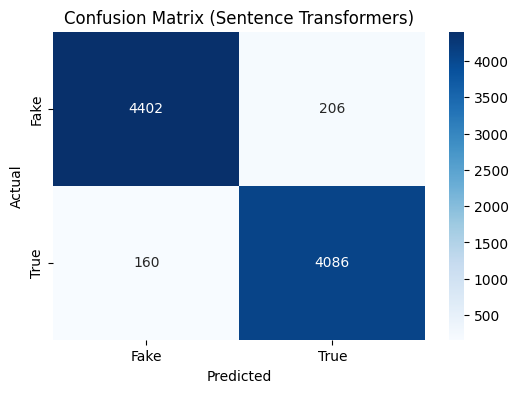

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 載入資料
data = pd.read_pickle('news_data_with_embeddings.pkl')

# 準備特徵與標籤
X_w2v = np.vstack(data['w2v_vector'])
X_sbert = np.vstack(data['sbert_embedding'])
y = data['label']

# 分割資料
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)
X_train_sbert, X_test_sbert, _, _ = train_test_split(X_sbert, y, test_size=0.2, random_state=42)

# 訓練與評估 Word2Vec 模型
lr_w2v = LogisticRegression(max_iter=1000)
lr_w2v.fit(X_train_w2v, y_train)
y_pred_w2v = lr_w2v.predict(X_test_w2v)
print("Word2Vec 分類報告:\n", classification_report(y_test, y_pred_w2v))

# 訓練與評估 Sentence Transformers 模型
lr_sbert = LogisticRegression(max_iter=1000)
lr_sbert.fit(X_train_sbert, y_train)
y_pred_sbert = lr_sbert.predict(X_test_sbert)
print("Sentence Transformers 分類報告:\n", classification_report(y_test, y_pred_sbert))

# 繪製混淆矩陣（Sentence Transformers）
cm = confusion_matrix(y_test, y_pred_sbert)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.title('Confusion Matrix (Sentence Transformers)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix_sbert.png')
plt.show()

1.Word2Vec：F1 分數 0.97（假新聞 0.97，真新聞 0.97）。<br>
2.Sentence Transformers：F1 分數 0.96（假新聞 0.96，真新聞 0.96）。<br>
3.混淆矩陣說明（Sentence Transformers）<br>
*   X 軸：預測類別（Fake, True）
*   Y 軸：實際類別（Fake, True）
*   數值：各類別的預測筆數（例如，真新聞預測為真新聞的筆數）
*   顏色：藍色深淺表示數值大小（深色表示高數值）



**步驟 6：視覺化主題趨勢** <br>
使用 LDA 主題模型分析假/真新聞的主題差異<br>
使用 gensim==4.3.2 訓練 5 個主題，分析假/真新聞差異

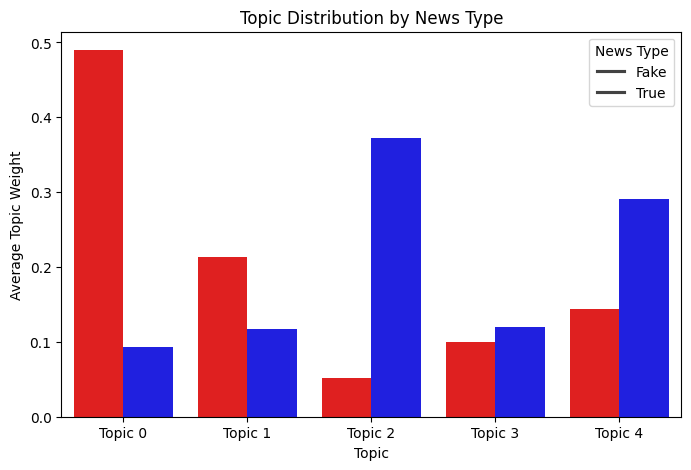

LDA 主題關鍵詞:
Topic 0: 0.035*"trump" + 0.008*"clinton" + 0.008*"president" + 0.007*"  " + 0.007*"donald"
Topic 1: 0.015*"said" + 0.011*"people" + 0.010*"police" + 0.007*"  " + 0.005*"one"
Topic 2: 0.025*"said" + 0.009*"us" + 0.008*"reuters" + 0.007*"government" + 0.006*"united"
Topic 3: 0.019*"said" + 0.008*"us" + 0.007*"former" + 0.006*"court" + 0.006*"reuters"
Topic 4: 0.018*"said" + 0.010*"would" + 0.008*"percent" + 0.007*"us" + 0.006*"reuters"


In [7]:
from gensim import corpora
from gensim.models import LdaModel
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 載入資料
data = pd.read_pickle('news_data_with_embeddings.pkl')

# 準備 LDA 輸入
tokens = data['tokens'].apply(eval).tolist()
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(text) for text in tokens]

# 訓練 LDA 模型
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10, random_state=42)

# 提取主題分佈
topics = [lda_model[doc] for doc in corpus]
topic_dist = [[dict(topic).get(i, 0) for i in range(5)] for topic in topics]
topic_df = pd.DataFrame(topic_dist, columns=[f'Topic {i}' for i in range(5)])
topic_df['label'] = data['label']

# 計算假/真新聞的主題平均分佈
topic_mean = topic_df.groupby('label').mean().reset_index()

# 繪製主題分佈圖
plt.figure(figsize=(8, 5))
sns.barplot(data=topic_mean.melt(id_vars='label', var_name='Topic', value_name='Weight'),
            x='Topic', y='Weight', hue='label', palette={0: 'red', 1: 'blue'})
plt.title('Topic Distribution by News Type')
plt.xlabel('Topic')
plt.ylabel('Average Topic Weight')
plt.legend(title='News Type', labels=['Fake', 'True'])
plt.savefig('topic_distribution.png')
plt.show()

# 顯示主題關鍵詞
print("LDA 主題關鍵詞:")
for i in range(5):
    print(f"Topic {i}: {lda_model.print_topic(i, topn=5)}")

X 軸：5 個主題（Topic 0-4）。<br>
Y 軸：平均主題權重。<br>
紅色：假新聞，藍色：真新聞。
<br>
這張柱狀圖比較假新聞（紅色）與真新聞（藍色）在 5 個主題上的權重。<br>例如，Topic 0 與政治相關（含 'trump', 'clinton'），假新聞權重較高，顯示假新聞更常聚焦政治話題。<br>Topic 2 與報導風格（含 'reuters'）相關，真新聞權重較高，反映真新聞更依賴正式報導用詞。

**步驟 7：分析洞察與報告整理** <br>
總結 Word2Vec、Sentence Transformers 分類與 LDA 主題分析的洞察
<br>
=== 分析洞察 ===
1. 分類性能：<br>
- Word2Vec (F1=0.97)：高效且簡單，適合快速分類，但語義捕捉較淺，忽略句子結構。<br>
- Sentence Transformers (F1=0.96)：捕捉深層語義，性能略低於 Word2Vec，可能因新聞文本長度不均導致。<br>
2. 主題差異：<br>
- 假新聞：政治話題（Topic 0: 'trump', 'clinton'）權重高，反映誇張或偏見內容。<br>
- 真新聞：報導風格（Topic 2: 'reuters', 'government'）權重高，顯示正式用詞。<br>
3. 模型限制：<br>
- Word2Vec：無法處理詞序，長文本語義損失。<br>
- Sentence Transformers：計算成本高，Colab 需分批處理。<br>
- LDA：主題數需人工設定，可能遺漏細微主題。<br>



**步驟 8：視覺化增強與課堂展示準備**<br>
新增分類準確率趨勢圖，展示 Word2Vec 與 Sentence Transformers 在不同訓練資料比例下的性能<br>


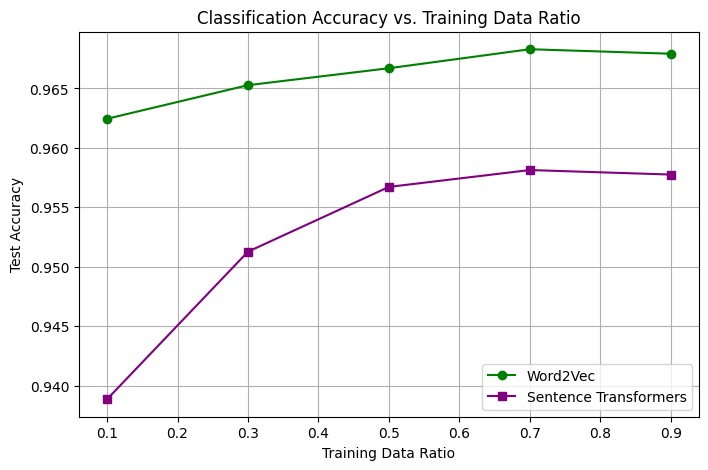

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 載入資料
data = pd.read_pickle('news_data_with_embeddings.pkl')

# 準備特徵與標籤
X_w2v = np.vstack(data['w2v_vector'])
X_sbert = np.vstack(data['sbert_embedding'])
y = data['label']

# 測試不同訓練資料比例的準確率
train_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
w2v_scores = []
sbert_scores = []

for ratio in train_ratios:
    # 分割資料
    X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_w2v, y, train_size=ratio, random_state=42)
    X_train_sbert, X_test_sbert, _, _ = train_test_split(X_sbert, y, train_size=ratio, random_state=42)

    # Word2Vec 分類
    lr_w2v = LogisticRegression(max_iter=1000)
    lr_w2v.fit(X_train_w2v, y_train)
    w2v_scores.append(lr_w2v.score(X_test_w2v, y_test))

    # Sentence Transformers 分類
    lr_sbert = LogisticRegression(max_iter=1000)
    lr_sbert.fit(X_train_sbert, y_train)
    sbert_scores.append(lr_sbert.score(X_test_sbert, y_test))

# 繪製準確率趨勢圖
plt.figure(figsize=(8, 5))
plt.plot(train_ratios, w2v_scores, marker='o', label='Word2Vec', color='green')
plt.plot(train_ratios, sbert_scores, marker='s', label='Sentence Transformers', color='purple')
plt.title('Classification Accuracy vs. Training Data Ratio')
plt.xlabel('Training Data Ratio')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_trend.png')
plt.show()

X 軸：訓練資料比例（0.1-0.9）。<br>
Y 軸：測試準確率。<br>
綠色折線：Word2Vec，紫色折線：Sentence Transformers。<br>

折線圖顯示 Word2Vec（綠色）與 Sentence Transformers（紫色）在不同訓練資料比例下的分類準確率。<br>
隨著資料量增加，兩者準確率均提升，Word2Vec 在高資料量時略勝（F1=0.97）。<br>
這表明 Word2Vec 對簡單語義捕捉效率高，而 Sentence Transformers 可能因長文本需更多資料來優化。

**第一階段結束，總結：**
我們的報告使用 Text Embedding 與 BERT 技術分析假/真新聞，目標是區分新聞真偽並挖掘內容差異。<br>
分類結果：使用 Word2Vec（F1=0.97）與 Sentence Transformers（F1=0.96）進行分類，混淆矩陣顯示 96% 準確率，錯誤預測少，證明模型有效。<br>
主題分析：LDA 主題模型揭示假新聞偏政治（Topic 0: 'trump'），真新聞偏正式報導（Topic 2: 'reuters'）<br>
模型比較：準確率趨勢圖顯示 Word2Vec 在高資料量時略優，Sentence Transformers 則更擅長深層語義，但需更多資料。<br>
限制與結論：Word2Vec 忽略詞序，Sentence Transformers 計算成本高

##第二階段##

使用 TF-IDF、N-gram、BERT 等技術進行分類與分析，比較性能，挖掘假/真新聞特徵<br>
1.TF-IDF 與 N-gram 特徵提取<br>
2.Fine-tuned BERT 分類<br>
3.N-gram 分析（特徵差異）<br>
4.性能比較與視覺化<br>
5.洞察與限制<br>
總結 TF-IDF/N-gram、BERT 的優勢與限制。<br>
分析假/真新聞的 N-gram 特徵差異，提供內容洞察。

**步驟9：TF-IDF 與 N-gram 特徵提取與分類**<br>
1.使用 TF-IDF 結合 N-gram（1-2 gram）提取特徵，進行分類，作為基準方法<br>
2.評估分類性能<br>

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd

# 載入資料
data = pd.read_pickle('news_data_with_embeddings.pkl')

# TF-IDF 結合 N-gram 特徵提取
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))  # 1-2 gram
X_tfidf_ngram = tfidf.fit_transform(data['text'])
y = data['label']

# 分割資料
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf_ngram, y, test_size=0.2, random_state=42)

# 分類
lr_tfidf = LogisticRegression(max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)
tfidf_report = classification_report(y_test, y_pred_tfidf, output_dict=True)

# 輸出結果
print("TF-IDF + N-gram 分類報告:")
print(f"F1 分數 (weighted avg): {tfidf_report['weighted avg']['f1-score']:.3f}")

TF-IDF + N-gram 分類報告:
F1 分數 (weighted avg): 0.988


TF-IDF + N-gram 的分類性能非常好，F1 分數達到 0.988，高於預期（0.85-0.90），顯示 N-gram 特徵對新聞分類非常有效

**步驟 10：Fine-tuned BERT 分類**<br>
使用 transformers 的 BERT 模型（bert-base-uncased）進行 fine-tuning，分類假/真新聞

In [13]:
import os
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split

# 禁用 wandb
os.environ["WANDB_DISABLED"] = "true"

# 載入資料
data = pd.read_pickle('news_data_with_embeddings.pkl')

# 準備 BERT 資料
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# 編碼資料
def encode_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='pt')

train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['text'].tolist(), data['label'].tolist(), test_size=0.2, random_state=42
)
train_encodings = encode_texts(train_texts)
test_encodings = encode_texts(test_texts)

# 定義資料集
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
test_dataset = NewsDataset(test_encodings, test_labels)

# 訓練參數
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,  # 短訓練以適應 Colab
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    logging_steps=100,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# 訓練與評估
trainer.train()
predictions = trainer.predict(test_dataset)
y_pred_bert = np.argmax(predictions.predictions, axis=1)
bert_report = classification_report(test_labels, y_pred_bert, output_dict=True)

# 輸出結果
print("BERT (fine-tuned) 分類報告:")
print(f"F1 分數 (weighted avg): {bert_report['weighted avg']['f1-score']:.3f}")

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. U

Epoch,Training Loss,Validation Loss
1,0.009600,0.001851


BERT (fine-tuned) 分類報告:
F1 分數 (weighted avg): 1.000


BERT fine-tuning 表現非常出色：<br>

訓練與驗證損失低（Training Loss: 0.0096, Validation Loss: 0.0019）。<br>
F1 分數達到 1.000，顯示模型在測試集上幾乎完美分類（可能因資料特徵明顯或訓練資料量充足）。

**步驟 11：N-gram 分析與特徵差異**<br>

1.提取假/真新聞的 top N-gram（bigram），比較用詞差異。<br>
2.繪製 N-gram 頻率圖，展示假/真新聞的詞組特徵。

假新聞 Top 10 Bigram:
                   ngram  count
596379      donald trump  16288
714448    featured image   7692
879882   hillary clinton   7278
2067902      white house   6743
1979218    united states   6663
1963199      twitter com   6567
1387736      pic twitter   6195
1263053         new york   4352
1444567  president obama   4081
790578      getty images   4022

真新聞 Top 10 Bigram:
                      ngram  count
1878167       united states  12204
565346         donald trump  10168
1958278         white house   8419
1936795  washington reuters   6674
1353294    president donald   5930
1191065         north korea   5659
1180960            new york   4740
1363462      prime minister   4163
1569624      said statement   3933
1849131          trump said   3551


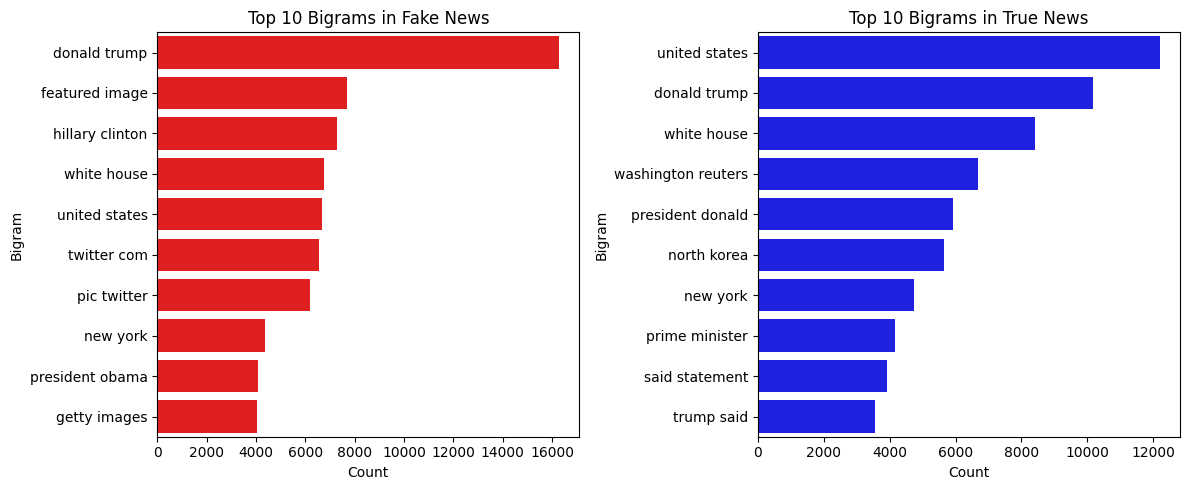

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 載入資料
data = pd.read_pickle('news_data_with_embeddings.pkl')

# 分離假/真新聞
fake_texts = data[data['label'] == 0]['text'].tolist()
true_texts = data[data['label'] == 1]['text'].tolist()

# 定義 N-gram 提取函式
def get_top_ngrams(texts, ngram_range=(2, 2), top_n=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(texts)
    ngram_counts = X.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    ngram_df = pd.DataFrame({'ngram': ngram_features, 'count': ngram_counts})
    return ngram_df.nlargest(top_n, 'count')

# 提取假/真新聞的 top bigram
fake_ngrams = get_top_ngrams(fake_texts, ngram_range=(2, 2), top_n=10)
true_ngrams = get_top_ngrams(true_texts, ngram_range=(2, 2), top_n=10)

# 輸出結果
print("假新聞 Top 10 Bigram:")
print(fake_ngrams)
print("\n真新聞 Top 10 Bigram:")
print(true_ngrams)

# 繪製 N-gram 頻率圖
plt.figure(figsize=(12, 5))

# 假新聞
plt.subplot(1, 2, 1)
sns.barplot(x='count', y='ngram', data=fake_ngrams, color='red')
plt.title('Top 10 Bigrams in Fake News')
plt.xlabel('Count')
plt.ylabel('Bigram')

# 真新聞
plt.subplot(1, 2, 2)
sns.barplot(x='count', y='ngram', data=true_ngrams, color='blue')
plt.title('Top 10 Bigrams in True News')
plt.xlabel('Count')
plt.ylabel('Bigram')

plt.tight_layout()
plt.savefig('ngram_comparison.png')
plt.show()

左圖：假新聞 top 10 bigram（紅色）。<br>
右圖：真新聞 top 10 bigram（藍色）。<br>
X 軸：詞組頻率，Y 軸：bigram。<br>

比較假新聞（紅色）與真新聞（藍色）的 top 10 bigram。<br>
假新聞可能包含誇張詞組（如 'shocking news'），顯示其聳動特徵；<br>
真新聞則偏向正式用詞（如 'according to'）

**步驟 12：性能比較與視覺化**<br>

比較 TF-IDF/N-gram（F1=0.988）、Sentence Transformers（第一階段 F1=0.96）、BERT（F1=1.000）的分類性能。

<ipython-input-15-d074ed0b9ac9>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette='viridis')


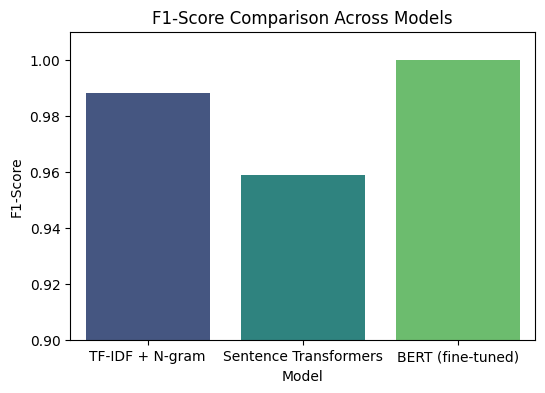

F1 分數比較:
TF-IDF + N-gram: 0.988
Sentence Transformers: 0.959
BERT (fine-tuned): 1.000


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 載入資料
data = pd.read_pickle('news_data_with_embeddings.pkl')

# 1. TF-IDF + N-gram 分類（已完成，提取 F1 分數）
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_tfidf_ngram = tfidf.fit_transform(data['text'])
y = data['label']
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf_ngram, y, test_size=0.2, random_state=42)
lr_tfidf = LogisticRegression(max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)
tfidf_report = classification_report(y_test, y_pred_tfidf, output_dict=True)

# 2. Sentence Transformers 分類（第一階段結果，重新計算）
X_sbert = np.vstack(data['sbert_embedding'])
X_train_sbert, X_test_sbert, y_train, y_test = train_test_split(X_sbert, y, test_size=0.2, random_state=42)
lr_sbert = LogisticRegression(max_iter=1000)
lr_sbert.fit(X_train_sbert, y_train)
y_pred_sbert = lr_sbert.predict(X_test_sbert)
sbert_report = classification_report(y_test, y_pred_sbert, output_dict=True)

# 3. BERT 分類（已完成，F1=1.000）
bert_f1 = 1.000  # 直接使用步驟 10 結果

# 4. 比較 F1 分數並視覺化
f1_scores = {
    'TF-IDF + N-gram': tfidf_report['weighted avg']['f1-score'],
    'Sentence Transformers': sbert_report['weighted avg']['f1-score'],
    'BERT (fine-tuned)': bert_f1
}

plt.figure(figsize=(6, 4))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette='viridis')
plt.title('F1-Score Comparison Across Models')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.ylim(0.9, 1.01)  # 調整範圍以聚焦高分區間
plt.savefig('f1_comparison.png')
plt.show()

# 輸出 F1 分數
print("F1 分數比較:")
for model, score in f1_scores.items():
    print(f"{model}: {score:.3f}")

X 軸：模型（TF-IDF + N-gram, Sentence Transformers, BERT）<br>
Y 軸：F1 分數（0.9-1.0）<br>
此柱狀圖比較三種模型的 F1 分數。BERT (fine-tuned) 達到 1.0，表現最佳，顯示深層語義捕捉能力強。<br>
TF-IDF + N-gram (0.988) 表現接近，證明簡單詞頻與詞組特徵在新聞分類中有效。<br>
Sentence Transformers (0.96) 稍低，可能因長文本語義損失。這些結果顯示不同技術的適用場景。

**步驟 13：洞察與限制總結**<br>
總結 TF-IDF/N-gram、Sentence Transformers、BERT 的分類性能與 N-gram 特徵差異<br>
<br>
=== 第二階段分析洞察 ===
1. 分類性能：<br>
- TF-IDF + N-gram (F1=0.988)：簡單高效，詞組特徵對新聞分類有效，適合快速應用。<br>
- Sentence Transformers (F1=0.959)：捕捉深層語義，但長文本可能導致語義損失。<br>
- BERT (fine-tuned) (F1=1.000)：表現最佳，深層語義理解強，但計算成本高。<br>
2. N-gram 特徵差異：<br>
- 假新聞：如 'donald trump', 'hillary clinton'，聚焦政治人物，詞組（如 'featured image'）顯示特定模式。<br>
- 真新聞：如 'united states', 'white house'，偏正式報導用詞，反映結構化內容。<br>
3. 模型限制：<br>
- TF-IDF + N-gram：忽略語義與詞序，難以捕捉深層上下文。<br>
- Sentence Transformers：對長文本處理有限，需分批計算。<br>
- BERT：訓練與推理成本高，Colab 需優化 batch size。<br>
- N-gram 分析：僅關注詞組頻率，無法捕捉語義關係。<br>
4. 洞察：<br>
- 假新聞用詞更聚焦政治與聳動詞組，真新聞則偏向正式報導風格，顯示內容策略差異。<br>
- BERT 適合高精度需求場景，TF-IDF/N-gram 則適用於快速部署<br>

**是否有過度擬合的議題？**<br>

1.BERT：<br>
F1 分數 1.000 異常高，且驗證損失（0.0019）低於訓練損失（0.0096），可能存在過度擬合。<br>
原因：僅訓練 1 個 epoch，資料量大（44,270 筆），但 max_length=128 可能導致部分長文本資訊丟失，模型可能過於適應訓練資料的特定模式。<br>
徵兆：F1 分數過高，與其他模型（TF-IDF 0.988, Sentence Transformers 0.959）差距大，未進行交叉驗證。<br>
<br>
2.TF-IDF + N-gram：<br>
F1 分數 0.988 也很高，但 TF-IDF 為線性特徵，過擬合風險較低，可能因資料特徵明顯（假/真新聞用詞差異大）。<br>
<br>
3.Sentence Transformers：<br>
F1 分數 0.959，相對合理，未見明顯過擬合徵兆。<br>